# E2a: Küchentischversuch zum Laval-Rotor

Name:Hiab Berhane
Datum:06.01.2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: Wie genau können die Schwingungen alltäglicher Geräte mit einem einfachen Schwingungssensor erfasst werden und dannch analysiert werden?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="Bilder/Handy.jpg" width="500">

- Beschreibung des Aufbaus: Ich habe den Sensor an mein Handy befestigt dies habe ich mit einem Tesafilmstreifen gemacht und habe das Handy auf meinem Schreibtisch gelegt
- Vorgangsbeschreibung:Bei meinem ersten Versuch habe ich die Vibaration beim Wecker gemessen anhand meines Handys. Dabei habe ich mir einfach einen Timer gestellt der auf 3 sekunden gestellt war und habe dann die Messung gestartet nach etwa so 1 bis 2 sekunden hat dan mein Wecker geklingelt und der Sensor hat dann diese Vibaration bzw Schwingung aufgezeichnet.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py as h5
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20240106_201011_HiabBerhane_handy" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240106_201011_HiabBerhane_handy.h5" # replace None by the filename of the hdf5-file

path_to_file = "measurement_data/data_20240106_201011_HiabBerhane_handy/data_20240106_201011_HiabBerhane_handy.h5"
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

#print(json.dumps(setup_json_dict, indent=2, default=str))
#print(json.dumps(sensor_settings_dict, indent=2, default=str))
#print("Probe: {}".format(probe_name))


#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
file = h5.File(path_to_file, 'r')
print(file.keys())

rawdata = file.get("RawData")
print(rawdata.keys())

data = rawdata.get("1ee847be-fddd-6ee4-892a-68c4555b0981")
print(data.keys())

        
time = np.array(data['timestamp'])
acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])
print(type(acceleration_x))
print(type(acceleration_y))
print(type(acceleration_z))


<KeysViewHDF5 ['RawData']>
<KeysViewHDF5 ['1ee847be-fddd-6ee4-892a-68c4555b0981']>
<KeysViewHDF5 ['acceleration_x', 'acceleration_y', 'acceleration_z', 'timestamp']>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
abb_vek_pp = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
print(type(abb_vek_pp))
print(abb_vek_pp)

<class 'numpy.ndarray'>
[10.4721064  10.4721064  10.4721064  ... 10.51748468 10.57322424
 10.57322424]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'Δt')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


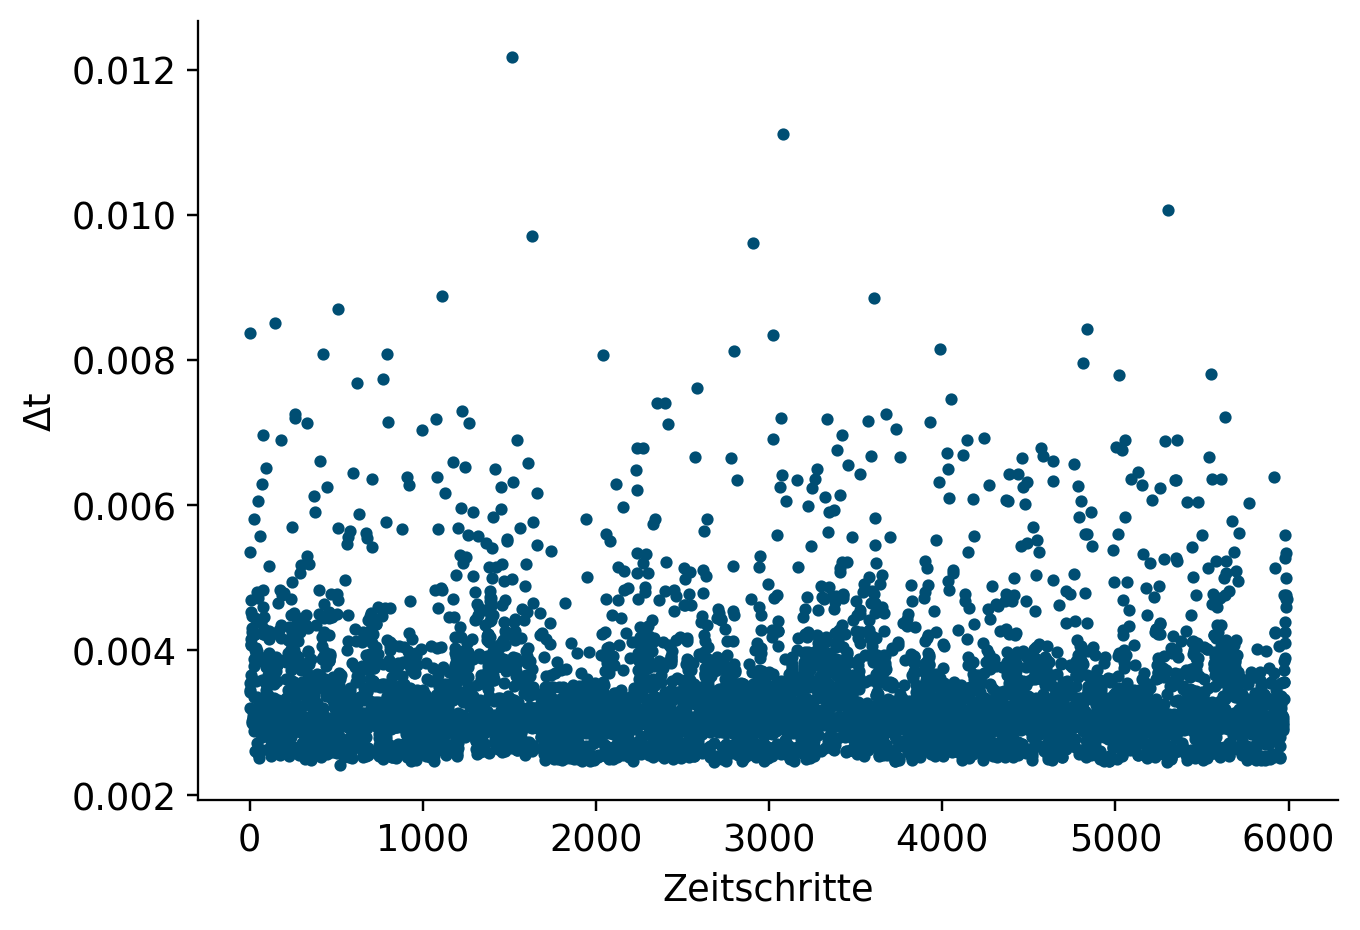

In [6]:
fig = plt.figure()
plt.plot(time, abb_vek_pp)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')

delta_t_liste = []
for i in range(1, (len(time))):
    delta_t_liste.append(time[i] - time[i-1])
    
fig2 = plt.figure()
plt.plot(delta_t_liste, '.')
plt.xlabel('Zeitschritte')
plt.ylabel('Δt')

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
interpolation_data = interpolation(time, abb_vek_pp)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

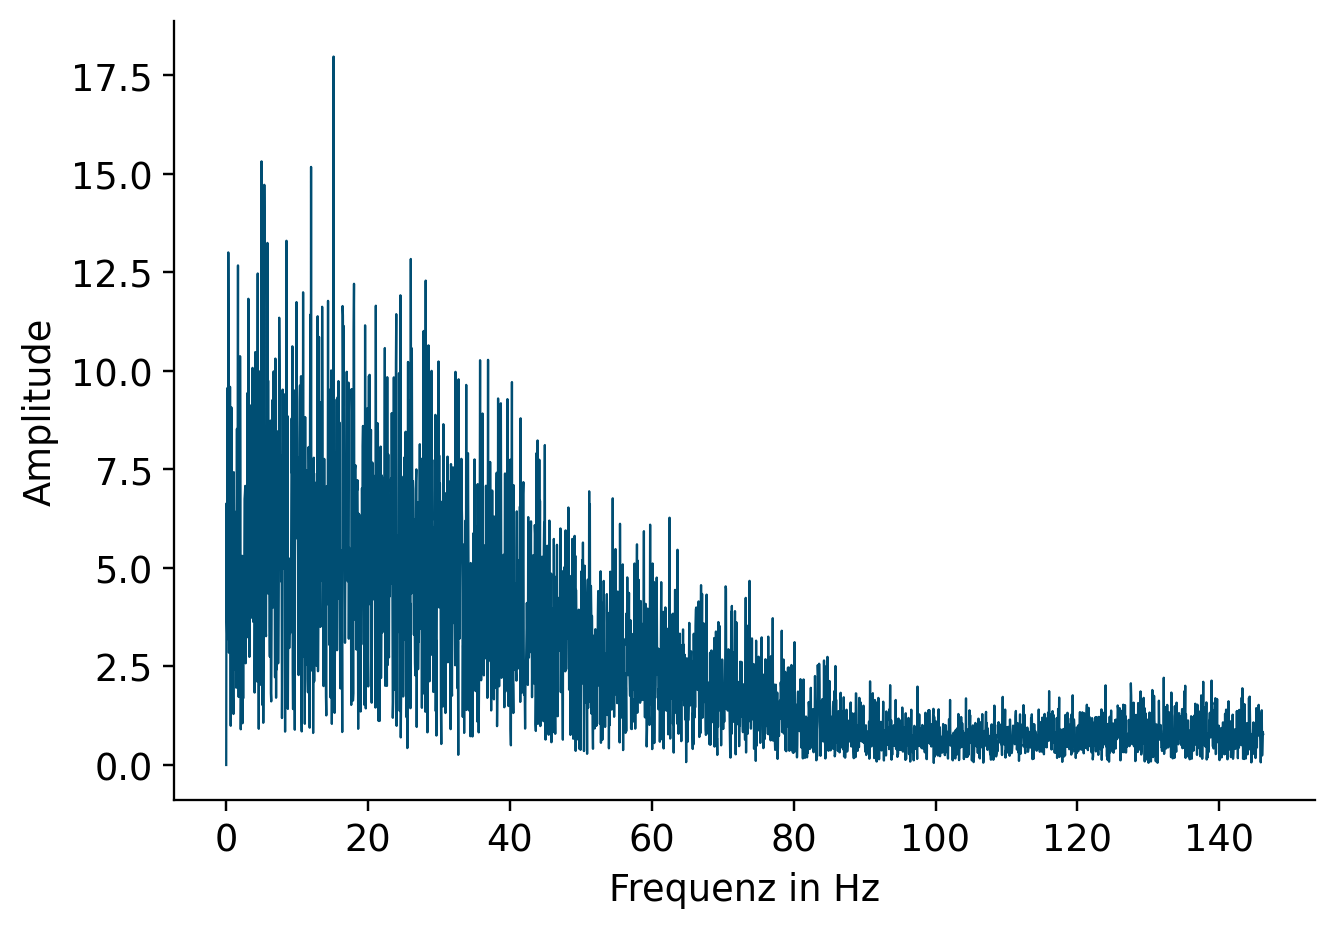

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
X_oneside, f_oneside = my_fft(interpolation_data, time)

fig2 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz in Hz')
plt.ylabel('Amplitude')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="Bilder/laptop.jpg" width="500">

- Beschreibung des Aufbaus: Wie beim ersten Versuch habe ich den Sensor mit Teas befestigt beim zweiten Versuch an meinem Laptop bewusst an der eher rechten seite da dort mein Lüfter ist
- Vorgangsbeschreibung: In diesem Versuch wollte ich die Schwingungen messen die enstehen wenn ich meinen Laptop voll auslaste, desswegen habe ich einen hochleistungstest gemacht, der viel Leistung beansprucht und habe diesen ein parr Minuten laufen lassen und habe dann die Messung gestartet

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [9]:
path_measurement_folder = "measurement_data/data_20240106_202940_HiabBerhane_laptop" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240106_202940_HiabBerhane_laptop.h5"

path_to_file = "measurement_data/data_20240106_202940_HiabBerhane_laptop/data_20240106_202940_HiabBerhane_laptop.h5"

"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

#print(json.dumps(setup_json_dict, indent=2, default=str))
#print(json.dumps(sensor_settings_dict, indent=2, default=str))
#print("Probe: {}".format(probe_name))

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [10]:
file = h5.File(path_to_file, 'r')
print(file.keys())

rawdata = file.get("RawData")
print(rawdata.keys())

data = rawdata.get("1ee847be-fddd-6ee4-892a-68c4555b0981")
print(data.keys())

        
time = np.array(data['timestamp'])
acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])
print(type(acceleration_x))
print(type(acceleration_y))
print(type(acceleration_z))

<KeysViewHDF5 ['RawData']>
<KeysViewHDF5 ['1ee847be-fddd-6ee4-892a-68c4555b0981']>
<KeysViewHDF5 ['acceleration_x', 'acceleration_y', 'acceleration_z', 'timestamp']>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### 2. Betrag der Beschleunigung berechnen


In [11]:
 abb_vek_pp = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
#print(type(abb_vek_pp))
#print(abb_vek_pp)

#### 3. Darstellung der Messdaten

Text(0, 0.5, 'Δt')

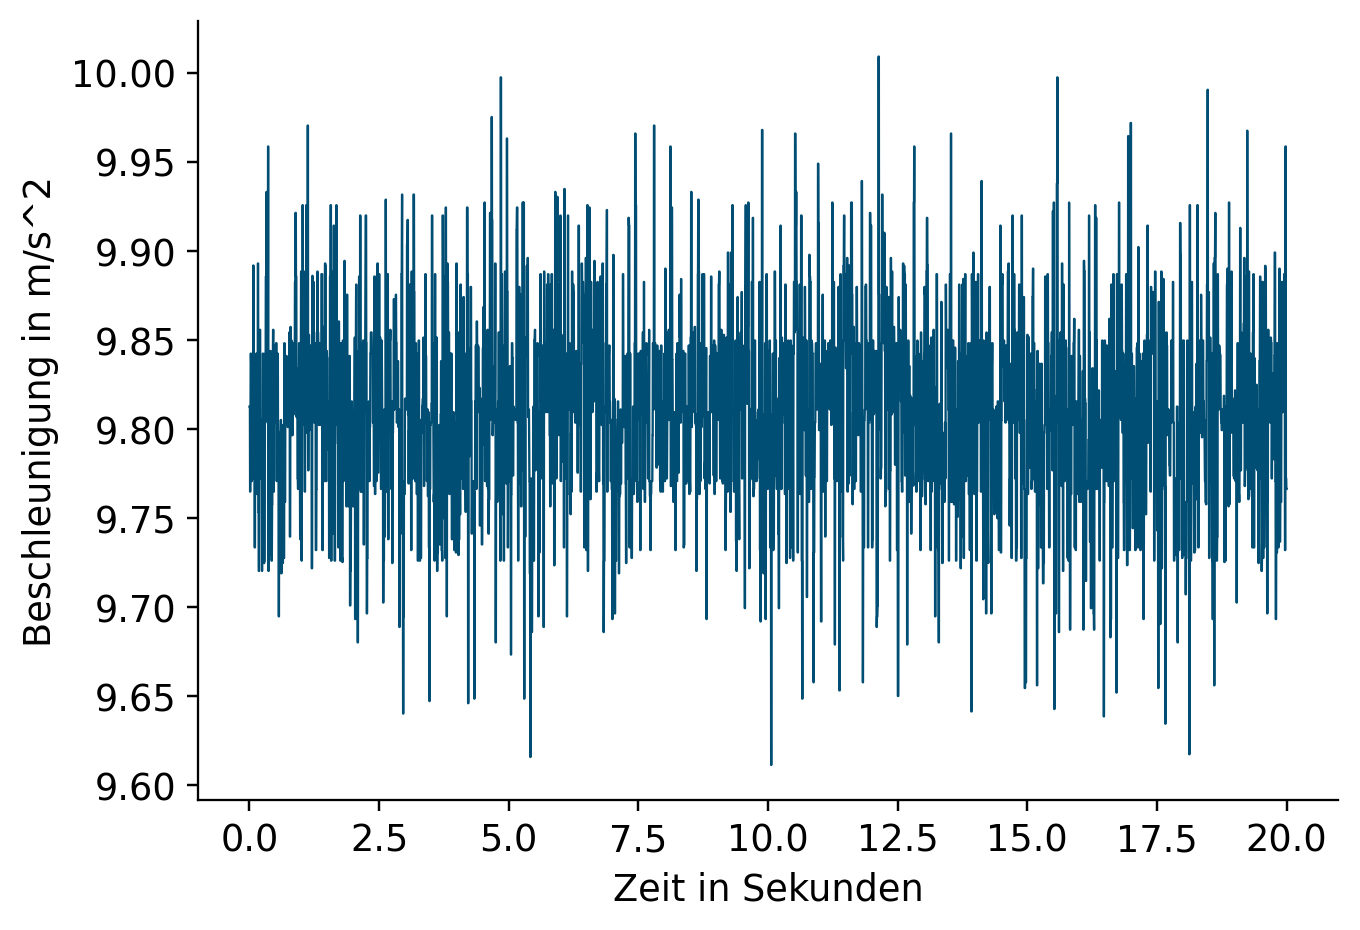

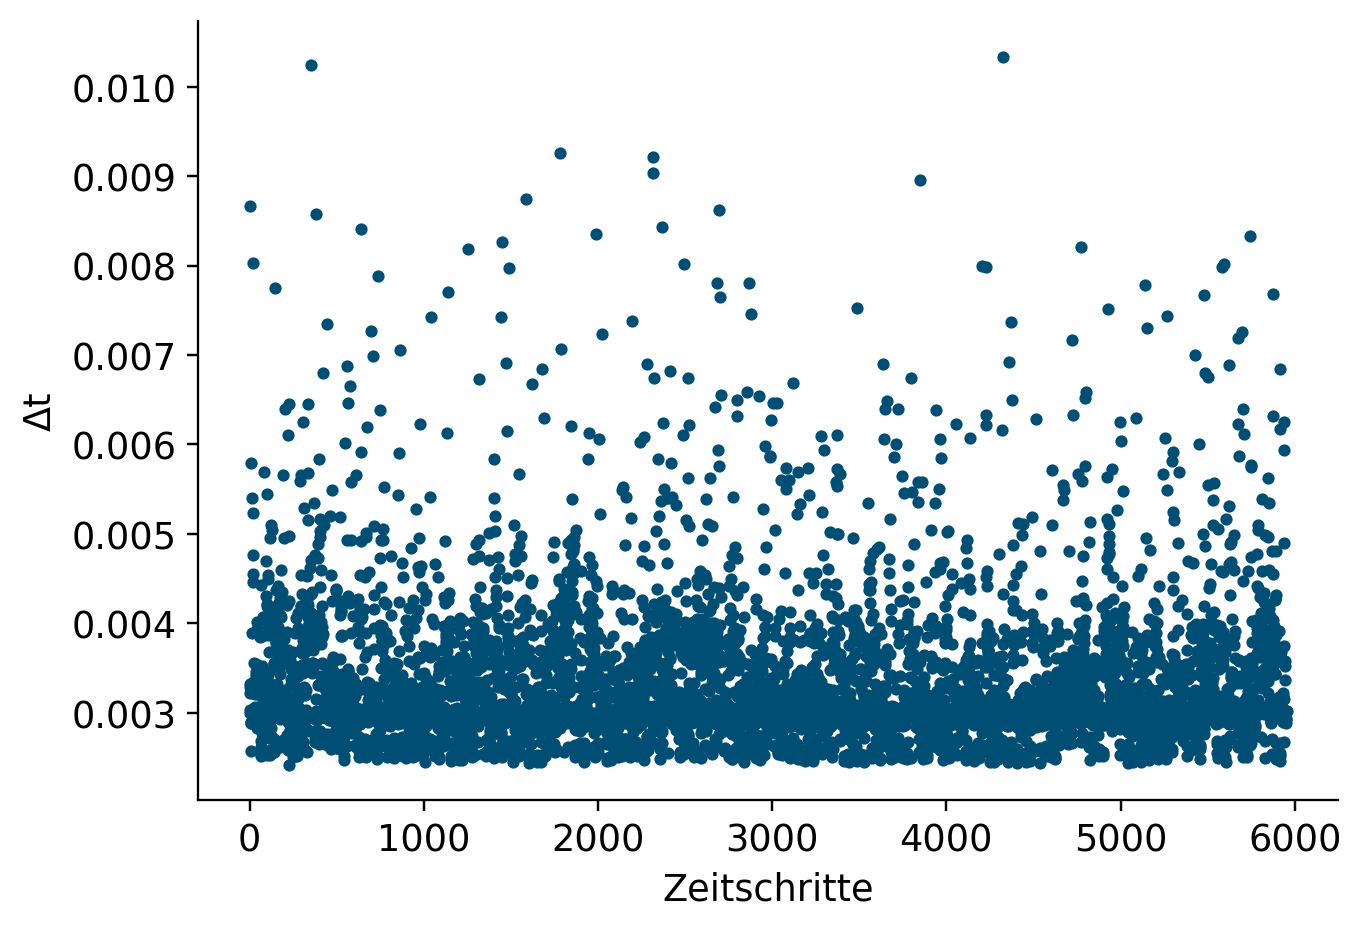

In [12]:
fig = plt.figure()
plt.plot(time, abb_vek_pp)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')

delta_t_liste = []
for i in range(1, (len(time))):
    delta_t_liste.append(time[i] - time[i-1])
    
fig2 = plt.figure()
plt.plot(delta_t_liste, '.')
plt.xlabel('Zeitschritte')
plt.ylabel('Δt')

#### 4. Interpolation der Messwerte



In [13]:
 interpolation_data = interpolation(time, abb_vek_pp)

#### 5 & 6. FFT durchführen und graphisch darstellen


Text(0, 0.5, 'Amplitude')

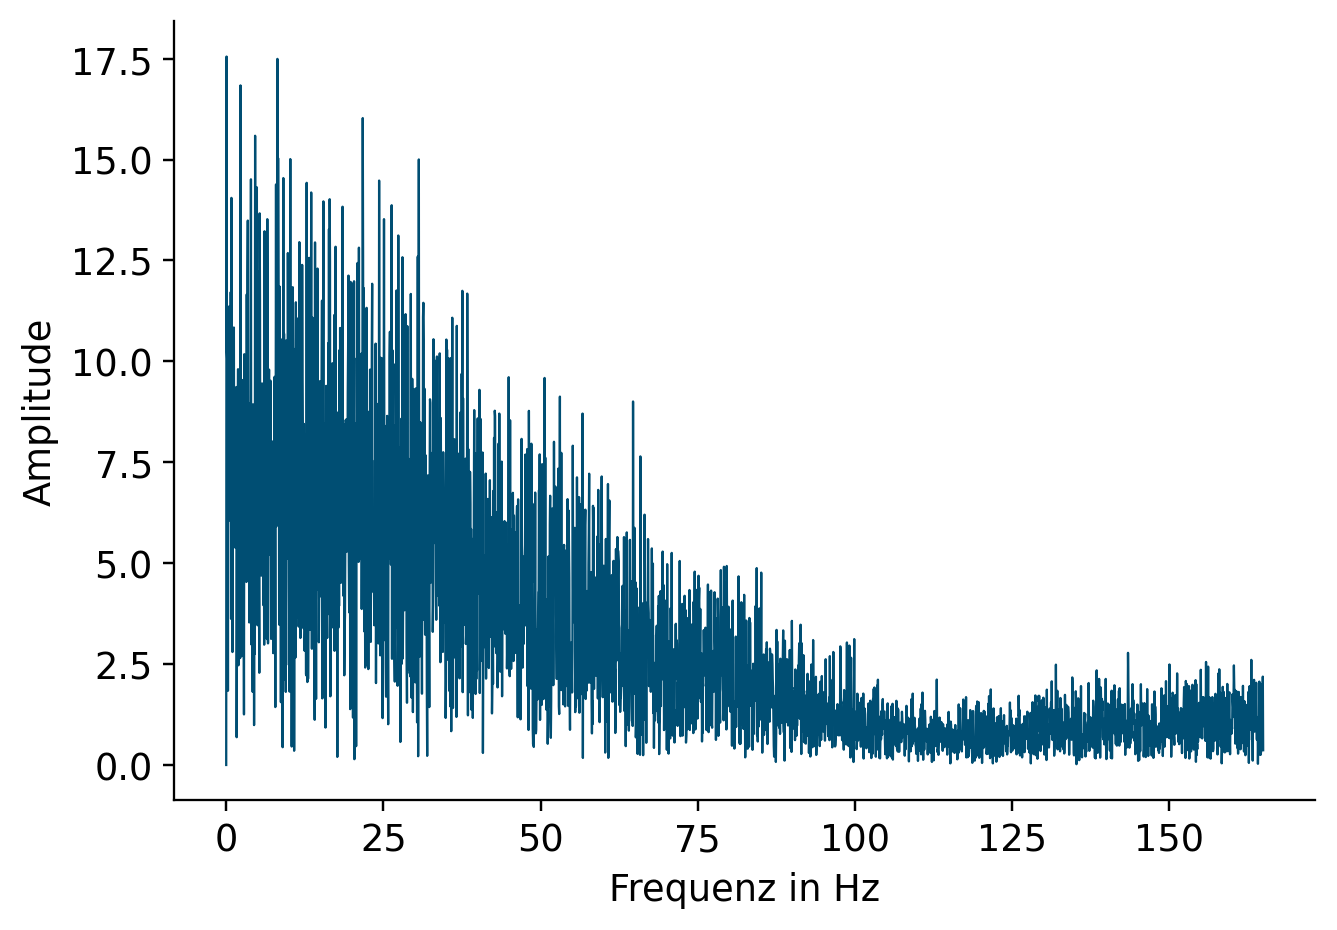

In [14]:
X_oneside, f_oneside = my_fft(interpolation_data, time)

fig2 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz in Hz')
plt.ylabel('Amplitude')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Amplitudenverläufe der einzelnen Experiment sehen sehr ähnlich aus dafür das es zwei ganz unterschiedliche Experimente sind, beim ersten Experiment habe ich bewusst eine Vibration gewählt die konsant ist, was sehr gut anm Beschleunigungsgraphen des ersten Versuchs zu sehen ist, natürlich gibt es verschiedene Weckereinstellungen aber meine Einstellung war ohne Ton und eine konstante Vibration. Beim zweiten Versuch wollte ich einfach wissen ob und welche Schwingungen enstehen wenn ich meinen Laptop voll auslaste, da es dann zu einem hohen Betriebes des Lüfters kommt. Obwohl die Graphen der Amplituden sich ähnlich sehen gibt es Unterschiede die man vorallem im Beschleunigungsgraphen sehen kann. Beim ersten Versuch ist der Y-Werte Bereich niedriger als beim zweiten Versuch, ausßerdem hat der erste Versuch bei diesem Graphen weniger Peaks die weniger stark hoch bzw. runter gehen.
Anhand der Darstellung der Zeitschritte ist zu erwähnen, dass sie sehr stark variieren und der Raspberry Pi inklusive Sensor nicht sehr genau sind.
Die Ergebnisse sind für die Annahmen, das es ein enifacher Sensor von einem Rasperry Pi ist und der Versuchsaufbau nicht optimal ist doch Aussagekräftiger als man denken könnte

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Die Versuche sind problemlos abgelaufen und was mich sehr gewundert hat ist die Ähnlichkeit der Versuche bei den Amplitudenverläufen, was ich daraus ziehen kann ist, dass wenn man annimmt das dieser Versuch durch seine Fehler nicht an Aussagekraft verliert, dass die Vibration meines Handyweckers vergleichbar sind mit den Schwingungen die enstehen wenn ich  meinen Laptop voll auslasten würde, was bei längeren nach denken logisch ist, da bei meinem zweiten Versuch der Lüfter meines Laptops sehr laut war.
Wie bei den vergangenen Abschnitten des Moduls gibt es immer Fehler die dem Aufbau geschuldet sind, zum Beispiel der Untergrund auf dem mein Handy war hätte einen UNterschied machen können oder auch ob die die Hülle des Handy drauflasse oder nicht genauso bei meinem Laptop hätte ich zum Beispiel mein Laptop auf einen weichen UNtergrund gelassen hätte das zu Änderungen in der Schwingung führen können.